In [1]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
A01T = h5py.File('datasets/A01T_slice.mat','r')
data = np.copy(A01T['image'])
labels = np.copy(A01T['type'])
labels = labels[0,0:data.shape[0]:1]
labels = np.asarray(labels, dtype=np.int32)

In [3]:
print data.shape

(288, 25, 313)


In [4]:
num_in = 10
num_hidden = 50

x = tf.placeholder(tf.float32)
W = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)

z = tf.matmul(W,x) + b
h = tf.maximum(z, tf.zeros(num_hidden))
loss = tf.pow(tf.reduce_sum(h)-1,2)

In [5]:
grad_x, grad_W, grad_b = tf.gradients(loss, [x,W,b])
print h

Tensor("Maximum:0", dtype=float32)


In [6]:
with tf.Session() as sess:
    values = {
        x: np.random.randn(num_in, 1),
        W: np.random.randn(num_hidden, num_in),
        b: np.random.randn(num_hidden)
    }
    out  = sess.run([h, grad_x, grad_W, grad_b], feed_dict=values)

In [7]:
print out[2].shape

(50, 10)


In [8]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64,[None])

W1 = tf.get_variable("W1", shape=[7, 7, 3, 32])
b1 = tf.get_variable("b1", shape=[32])
W2 = tf.get_variable("W2", shape=[5408,1024])
b2 = tf.get_variable("b2", shape=[1024])
W3 = tf.get_variable("W3", shape=[1024, 10])
b3 = tf.get_variable("b3", shape=[10])

a1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1], padding='VALID') + b1
h1 = tf.nn.relu(a1)
z2 = tf.nn.max_pool(h1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
z2_flat = tf.reshape(z2, [-1,5408])
a2 = tf.matmul(z2_flat,W2) + b2
h2 = tf.nn.relu(a2)
y_out = tf.matmul(h2,W3) + b3

total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)

mean_loss = tf.reduce_mean(total_loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [9]:
#Define weight updates
learning_rate =1e-2
grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3 = tf.gradients(mean_loss, [W1, b1, W2, b2, W3, b3])
new_W1 = W1.assign(W1 - learning_rate * grad_W1)
new_b1 = b1.assign(b1 - learning_rate * grad_b1)
new_W2 = W2.assign(W2 - learning_rate * grad_W2)
new_b2 = b2.assign(b2 - learning_rate * grad_b2)
new_W3 = W3.assign(W3 - learning_rate * grad_W3)
new_b3 = b3.assign(b3 - learning_rate * grad_b3)
updates = tf.group(new_W1,new_W2,new_W3,new_b1,new_b2,new_b3)

x_train = np.random.randn(64,32,32,3)
y_train = np.random.randint(0,10,64)
losses = []
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0 or "/gpu:0
        tf.global_variables_initializer().run() # initializes all variables
        feed_dict = {X: x_train,
                     y: y_train,
                    }
        for t in range(50):
            out = sess.run([mean_loss,updates],feed_dict=feed_dict)
            losses.append(out)

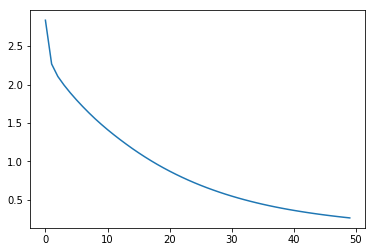

In [10]:
plt.plot(losses)
plt.show()